In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.optimize as opt
import scipy
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.cm as cm #Used to display images in a specific colormap
import os
import random
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [20]:
path = os.getcwd()
data = loadmat(path+'\ex3data1.mat')#its a dictionary
print 'Data:\n',data['X'].shape,'\n',data['X'],'\n'
print 'Target:\n',data['y'].shape,'\n',data['y'],'\n'

Data:
(5000L, 400L) 
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] 

Target:
(5000L, 1L) 
[[10]
 [10]
 [10]
 ..., 
 [ 9]
 [ 9]
 [ 9]] 



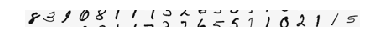

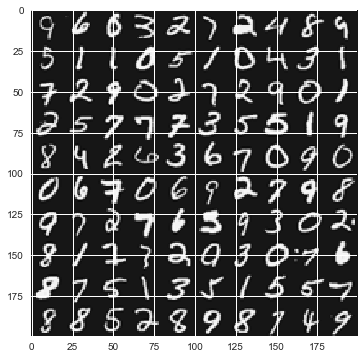

In [21]:
#Function to display images from pixel data (copied from other source)
def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x400,
    crates an image object from it, and returns it
    """
    width, height = 20, 20
    square = row.reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(data['X'].shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(data['X'][idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

sample = np.random.choice(data['X'].shape[0], 20)
plt.imshow(data['X'][sample,1:].reshape(-1,20).T)
plt.axis('off')

displayData()

In [22]:
def sigmoid(z):
    return(1/(1+np.exp(-z)))
sigmoid(0)

0.5

## Cost 
<img src ='Cost.png'>
## Cost Reg 
<img src='CostReg.png'>

In [23]:
def computeCost(weight,X,Y,isgrad = False) :
    y1 = Y*np.log(sigmoid(np.dot(X,weight)))
    y0 = (1-Y)*np.log(1-sigmoid(np.dot(X,weight)))
    cost = np.sum(-y1-y0)/len(X)
    if isgrad == False:
        return cost
    else:
        grad = gradient(weight, X, Y)
        return cost,grad
    
def computeCostReg(weight,X,Y,penalty) :
    y1 = Y*np.log(sigmoid(np.dot(X,weight)))
    y0 = (1-Y)*np.log(1-sigmoid(np.dot(X,weight)))
    cost = np.sum(-y1-y0)/len(X)
    reg = (penalty/(2*len(X)))*np.sum(np.power(weight[1:],2))
    costReg = cost + reg
    return costReg

## Gradient 
<img src='Gradient.png'>
## Gradient Reg 
<img src='GradientUp.png'>

In [24]:
#Calculate Gradient
def gradient(weight,X,Y):
    hx = sigmoid(np.dot(X,weight))
    error = hx - Y
    grad = np.dot(X.transpose(),error)/len(X)
    return grad

#Calculate Gradient With Regularization
def gradientReg(weight, X, Y, penalty):
    grad = np.zeros(len(weight))
    error = (sigmoid(np.dot(X,weight)) - Y)
    for i in range(len(weight)):
        effect = np.dot(X[:,i].transpose(),error)#np.dot(error, X[:,i]) #or 
        if (i == 0):
            grad[i] = effect / len(X)
        else:
            grad[i] = (effect / len(X)) + ((penalty / len(X)) * weight[i])
    return grad

#Calculate Gradient With Regularization - Vectorized Version
def gradientRegVec(weight, X, Y, penalty):
    error = (sigmoid(np.dot(X,weight)) - Y)
    effect = np.dot(X.transpose(),error)#np.dot(error, X[:,i]) #or 
    grad = (effect / len(X)) + ((penalty / len(X)) * weight)
    grad[0] = effect[0] / len(X)
    return grad

#Calculate Weights with Gradient Descent
def gradientDescent(X,Y,weight,alpha,iters):
    cost = np.zeros(iters)
    for j in range(iters):
        error = (np.dot(X,weight) - Y) #compute error and keep it same for each weight update for simultaneous update
        for i in range(len(weight)):
            effect = np.dot(X[:,i].transpose(),error)
            #term = np.multiply(error,X[:,i])#multiply error with each column and update weight
            dW = effect/len(X)
            weight[i] = weight[i] - (alpha*dW)
        cost[j] = computeCost(X,Y,weight)
    return weight,cost

#Calculate Weights with Gradient Descent - Vecotrized
def gradientDescentVec(X,Y,weight,alpha,iters):
    cost = np.zeros(iters)
    for j in range(iters):
        error = (np.dot(X,weight) - Y) #compute error and keep it same for each weight update for simultaneous update
        effect = np.dot(X.transpose(),error) #or np.dot(error,X)
        dW = effect/len(X)
        weight = weight - (alpha*dW)
        cost[j] = computeCost(X,Y,weight)
    return weight,cost

#Calculate Weights with Gradient Descent - Regularized
def gradientDescentReg(X,Y,weight,alpha,iters,penalty):
    cost = np.zeros(iters)
    for j in range(iters):
        error = (sigmoid(np.dot(X,weight)) - Y) #compute error and keep it same for each weight update for simultaneous update
        for i in range(len(weight)):
            effect = np.dot(X[:,i].transpose(),error)
            if i == 0:
                dW = (effect/len(X)) 
            else:
                dW = (effect/len(X)) + ((penalty / len(X)) * weight[i])
            weight[i] = weight[i] - (alpha*dW)
        cost[j] = computeCostReg(weight,X,Y,penalty)
    return weight,cost

#Calculate Weights with Gradient Descent - Regularized,Vecotorized
def gradientDescentRegVec(X,Y,weight,alpha,iters,penalty):
    cost = np.zeros(iters)
    for j in range(iters):
        error = (sigmoid(np.dot(X,weight)) - Y) #compute error and keep it same for each weight update for simultaneous update
        effect = np.dot(X.transpose(),error)
        dW = (effect/len(X)) + ((penalty / len(X)) * weight)
        dW[0] = (effect[0]/len(X)) 
        weight = weight - (alpha*dW)
        cost[j] = computeCostReg(weight,X,Y,penalty)
    return weight,cost

In [25]:
X = data['X']
Y = data['y']
#Y = np.reshape(Y,len(Y))
X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)
print np.unique(Y)
print np.zeros(X.shape[1]).shape
print Y.shape
print np.reshape(Y,len(Y)).shape
print Y.ravel().shape

[ 1  2  3  4  5  6  7  8  9 10]
(401L,)
(5000L, 1L)
(5000L,)
(5000L,)


In [26]:
def oneVsall(X,Y,penalty,num_labels,localAlgo = False,alpha = 0.1,iters =1000):
    weights = np.zeros(X.shape[1])
    all_weight = np.zeros((num_labels,X.shape[1]))
    
    for i in range(1,num_labels+1):
        Y_tr =np.array([1 if j == i else 0 for j in Y])
        #Y_tr =np.array([1 if j == i else 0 for j in Y]).reshape(len(Y),1)
        if localAlgo == False:
            result = opt.minimize(computeCostReg,x0= weights, method='L-BFGS-B',
                                   jac=gradientRegVec, args=(X, Y_tr, penalty))
            all_weight[i-1] = result.x
        else:
            new_weights,cost =gradientDescentRegVec(X,Y_tr,weights,alpha,iters,penalty)
            all_weight[i-1] = new_weights
        
    return all_weight

In [27]:
all_weights = oneVsall(X,Y,penalty=1,num_labels=10)
all_weights

C:\Users\stiwari\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: divide by zero encountered in log
C:\Users\stiwari\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in multiply
C:\Users\stiwari\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
C:\Users\stiwari\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: divide by zero encountered in log
C:\Users\stiwari\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in multiply


array([[ -7.24976297e+01,   0.00000000e+00,   0.00000000e+00, ...,
          1.46361962e-01,  -1.47856638e-05,   0.00000000e+00],
       [ -5.49233198e+02,   0.00000000e+00,   0.00000000e+00, ...,
          4.00785398e+01,  -1.19773383e+00,   0.00000000e+00],
       [ -1.12564180e+01,   0.00000000e+00,   0.00000000e+00, ...,
         -6.12056488e-04,  -1.15882131e-06,   0.00000000e+00],
       ..., 
       [ -1.29115009e+01,   0.00000000e+00,   0.00000000e+00, ...,
         -2.62119872e+00,   3.02790470e-01,   0.00000000e+00],
       [ -8.39440817e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -1.60342318e-01,   9.89623216e-03,   0.00000000e+00],
       [ -8.55516564e+01,   0.00000000e+00,   0.00000000e+00, ...,
         -5.64352205e-03,   2.17017038e-04,   0.00000000e+00]])

In [37]:
all_weights_gd = oneVsall(X,Y,penalty=1,num_labels=10,localAlgo=True,alpha=0.1,iters=10000)
all_weights_gd

array([[ -8.90769796e-01,   0.00000000e+00,   0.00000000e+00, ...,
          2.59590112e-04,   1.20684847e-07,   0.00000000e+00],
       [ -2.27208583e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.35176371e-03,  -1.55624850e-04,   0.00000000e+00],
       [ -3.31515267e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -1.51783758e-05,   1.70650733e-08,   0.00000000e+00],
       ..., 
       [ -5.92312721e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -7.23997344e-05,   6.74878144e-06,   0.00000000e+00],
       [ -3.40251949e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -1.78974999e-04,   9.93634719e-06,   0.00000000e+00],
       [ -2.53600957e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -2.19655427e-04,   8.28665870e-06,   0.00000000e+00]])

In [38]:
def predictOneVsAll(X, all_weights):
    probs = sigmoid(np.dot(X,all_weights.transpose()))
    return(np.argmax(probs, axis=1)+1)

### L-BFGS-B Prediction

In [39]:
pred = predictOneVsAll(X,all_weights)
print('Training set accuracy L-BFGS-B: {} %'.format(np.mean(pred == Y.ravel())*100))

Training set accuracy L-BFGS-B: 99.1 %


C:\Users\stiwari\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


### Gradient Descent Predictions

In [40]:
pred_gd = predictOneVsAll(X,all_weights_gd)
print('Training set accuracy gradient descent: {} %'.format(np.mean(pred_gd == Y.ravel())*100))

Training set accuracy gradient descent: 93.24 %


### SkLearn Predictions

In [32]:
clf = LogisticRegression(C=10, penalty='l2', solver='liblinear')
clf.fit(X[:,1:],Y.ravel())
pred = clf.predict(X[:,1:])
print('Training set accuracy Sklearn: {} %'.format(np.mean(pred == Y.ravel())*100))

Training set accuracy Sklearn: 96.5 %


### Neural Network Feed Forward Prediction

In [33]:
#Load Weights Already Provided
weights = loadmat(path+'\ex3weights.mat')
print 'Weight Keys:',weights.keys()

Weight Keys: ['Theta2', '__version__', '__header__', 'Theta1', '__globals__']


In [34]:
hiddenlayer_weight = weights['Theta1']
outputlayer_weight = weights['Theta2']
print hiddenlayer_weight.shape , outputlayer_weight.shape

(25L, 401L) (10L, 26L)


In [35]:
def predict(X,hiddenlayer_weight, outputlayer_weight):
    hidden_layer = sigmoid(np.dot(X,hiddenlayer_weight.transpose()))
    #Add Bias Neuron to hidden layer
    a2 = np.c_[np.ones((X.shape[0],1)), hidden_layer]
    output_layer = sigmoid(np.dot(a2,outputlayer_weight.transpose()))
    print output_layer.shape
    return(np.argmax(output_layer, axis=1)+1)

In [36]:
pred_nn = predict(X,hiddenlayer_weight, outputlayer_weight)
print('Training set accuracy: {} %'.format(np.mean(pred_nn == Y.ravel())*100))

(5000L, 10L)
Training set accuracy: 97.52 %
